# Analisis Keterlambatan & Akurasi Waktu

### Pernyataan Masalah 
Berdasarkan data operasional, ditemukan indikasi bahwa 100% pesanan mengalami keterlambatan (delay) ketika membandingkan waktu aktual pengiriman (Delivery Duration) dengan estimasi yang diberikan aplikasi (Estimated Duration).

Ketidakakuratan ini bukan kejadian acak, melainkan pola sistematis di mana estimasi aplikasi selalu lebih rendah (terlalu optimis) dibandingkan realita di lapangan. Hal ini berisiko tinggi menurunkan kepercayaan dan kepuasan pelanggan terhadap layanan.

### Tujuan Analisis (Objectives)
Analisis ini bertujuan untuk membedah akar penyebab ketidakakuratan tersebut melalui pendekatan data (data-driven), dengan rincian sebagai berikut:
1. Validasi Masalah: Mengonfirmasi secara statistik tingkat keterlambatan 100% dan mengukur seberapa besar rata-rata kesenjangan (gap) waktunya.
2. Audit Algoritma Estimasi: Mengevaluasi apakah algoritma estimasi saat ini hanya mengandalkan jarak (linear) dan mengabaikan variabel realita seperti kondisi lalu lintas.
3. Analisis Faktor Eksternal & Internal:
    - Eksternal: Mengukur dampak kemacetan (Traffic Level) terhadap durasi pengiriman.
    - Internal: Mengidentifikasi apakah kompleksitas pesanan (ukuran pizza) berkontribusi pada keterlambatan di sisi dapur.

In [21]:
#Import Library & Load Data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Konfigurasi Visualisasi
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load Dataset
df = pd.read_excel(r"C:\Users\Acerswift_93400\Downloads\Internship\Analisis Keterlambatan\data_pizza.xlsx")

# Menghitung Gap Waktu (Selisih)
# Gap positif artinya terlambat, negatif artinya lebih cepat dari estimasi
df['Gap Time (min)'] = df['Delivery Duration (min)'] - df['Estimated Duration (min)']

# Verifikasi Masalah: Berapa persen yang Actual > Estimated?
late_percentage = (df[df['Gap Time (min)'] > 0].shape[0] / df.shape[0]) * 100
print(f"Persentase pesanan yang durasi aktualnya melebihi estimasi: {late_percentage}%")
print(f"Rata-rata keterlambatan (Gap): {df['Gap Time (min)'].mean():.2f} menit")

Persentase pesanan yang durasi aktualnya melebihi estimasi: 100.0%
Rata-rata keterlambatan (Gap): 17.62 menit


### Analisis 1: Bukti Kegagalan Algoritma Estimasi
Tujuan: Memvisualisasikan seberapa jauh perbedaan antara "Janji Aplikasi" (Estimasi) dengan "Realita Lapangan" (Aktual).

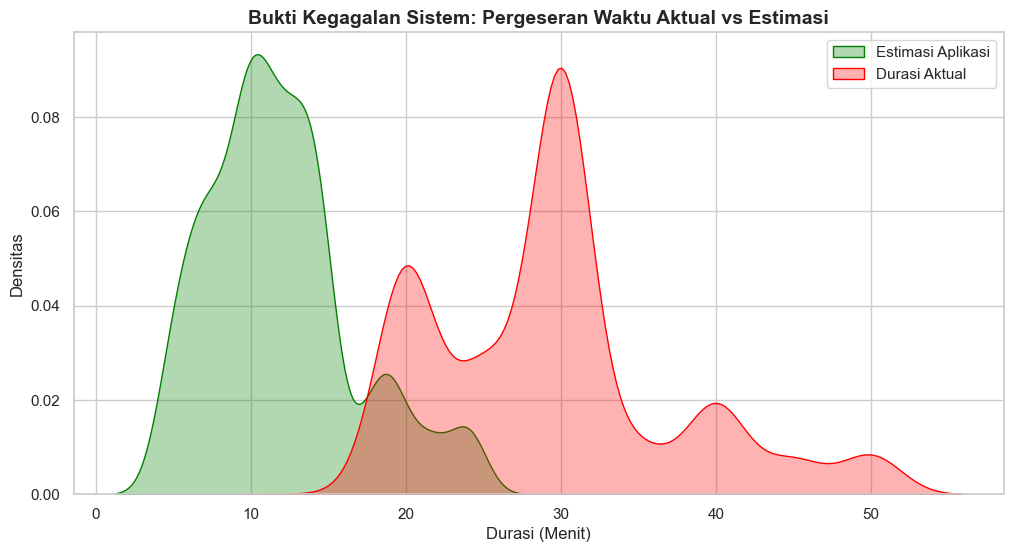

In [14]:
# Distribusi Estimasi vs Aktual
plt.figure(figsize=(12, 6))

# Plot Estimasi (Warna Hijau)
sns.kdeplot(df['Estimated Duration (min)'], fill=True, color='green', label='Estimasi Aplikasi', alpha=0.3)

# Plot Aktual (Warna Merah)
sns.kdeplot(df['Delivery Duration (min)'], fill=True, color='red', label='Durasi Aktual', alpha=0.3)

plt.title('Bukti Kegagalan Sistem: Pergeseran Waktu Aktual vs Estimasi', fontsize=14, fontweight='bold')
plt.xlabel('Durasi (Menit)')
plt.ylabel('Densitas')
plt.legend()
plt.show()

#### Insight:

Pergeseran Sistematis: Grafik menunjukkan dua "gunung" yang terpisah. Gunung hijau (Estimasi) berada di angka rendah (sekitar 5-15 menit), sedangkan gunung merah (Aktual) berada di angka tinggi (20-30 menit).

Ini bukan anomali kejadian sesekali, tapi kesalahan sistematis. Kemungkinan besar algoritma estimasi terlalu optimis dan tidak memperhitungkan realita lapangan, menyebabkan gap rata-rata yang konsisten di semua pesanan.

### Analisis 2: Apakah Karena Jarak? (The Distance Trap)
Tujuan: Mengecek apakah algoritma estimasi sudah memperhitungkan jarak dengan benar.

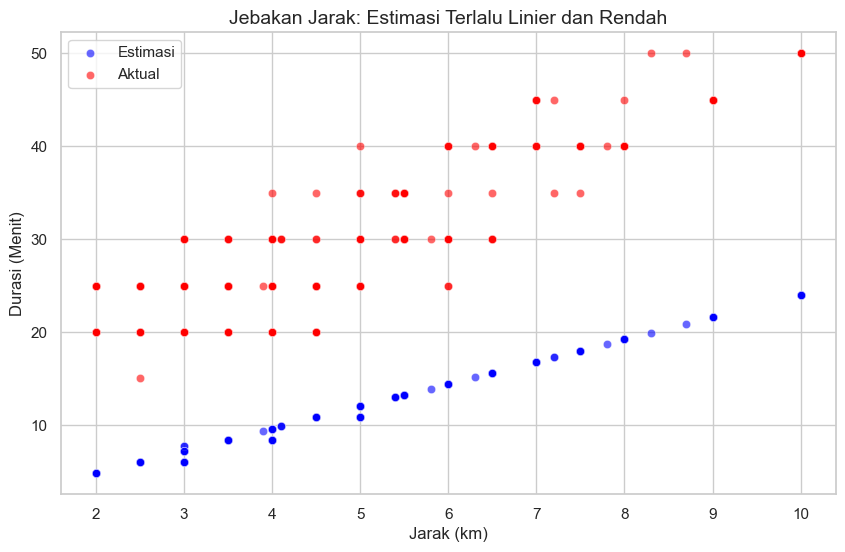

Korelasi Estimasi vs Jarak: 0.9969


In [15]:
# Korelasi & Scatter Plot Estimasi vs Jarak
plt.figure(figsize=(10, 6))

# Scatter plot untuk melihat pola
sns.scatterplot(x='Distance (km)', y='Estimated Duration (min)', data=df, color='blue', label='Estimasi', alpha=0.6)
sns.scatterplot(x='Distance (km)', y='Delivery Duration (min)', data=df, color='red', label='Aktual', alpha=0.6)

plt.title('Jebakan Jarak: Estimasi Terlalu Linier dan Rendah', fontsize=14)
plt.xlabel('Jarak (km)')
plt.ylabel('Durasi (Menit)')
plt.legend()
plt.show()

# Cek Korelasi
corr_est_dist = df['Estimated Duration (min)'].corr(df['Distance (km)'])
print(f"Korelasi Estimasi vs Jarak: {corr_est_dist:.4f}")

#### Insight 

Korelasi Sempurna (0.99): Estimasi waktu memiliki korelasi yang hampir sempurna dengan jarak. Ini berarti algoritma kemungkinan besar hanya menggunakan rumus sederhana, yaitu: Waktu = Jarak / Kecepatan.

Kecepatan Tidak Realistis: Garis biru (Estimasi) berada jauh di bawah garis merah (Aktual). Ini berarti parameter "Kecepatan" dalam rumus tersebut terlalu tinggi (misal: menganggap kurir bisa melaju cepat 60km/jam di kota padat, padahal realitanya macet).

### Analisis 3: Dampak Kemacetan (Traffic Level)
Tujuan: Melihat apakah kemacetan memperparah keterlambatan.

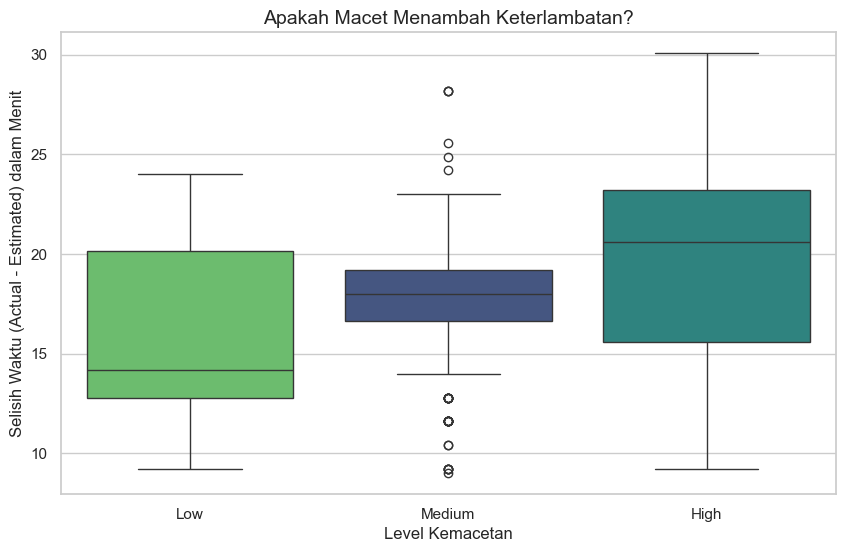

In [19]:
# Dampak Traffic terhadap Gap Keterlambatan (REVISI)
plt.figure(figsize=(10, 6))

# Mengurutkan level traffic
order_traffic = ['Low', 'Medium', 'High']

# PERBAIKAN: Menambahkan hue=... dan legend=False
sns.boxplot(
    x='Traffic Level', 
    y='Gap Time (min)', 
    data=df, 
    order=order_traffic, 
    palette='viridis', 
    hue='Traffic Level', 
    legend=False         
)

plt.title('Apakah Macet Menambah Keterlambatan?', fontsize=14)
plt.ylabel('Selisih Waktu (Actual - Estimated) dalam Menit')
plt.xlabel('Level Kemacetan')
plt.show()

#### Insight:

Semua Level Terlambat: Bahkan pada traffic Low (Sepi), Gap Time masih positif (terlambat). Ini mengonfirmasi bahwa masalah utamanya bukan cuma macet.

Eskalasi: Traffic High memang memperparah keterlambatan (kotak diagram lebih tinggi), tetapi bukan satu-satunya penyebab. Estimasi aplikasi gagal memberikan buffer time untuk kondisi macet.

### Analisis 4: Efisiensi Dapur (Operational Check)
Tujuan: Mengecek apakah kompleksitas pesanan (ukuran pizza) mempengaruhi keterlambatan.

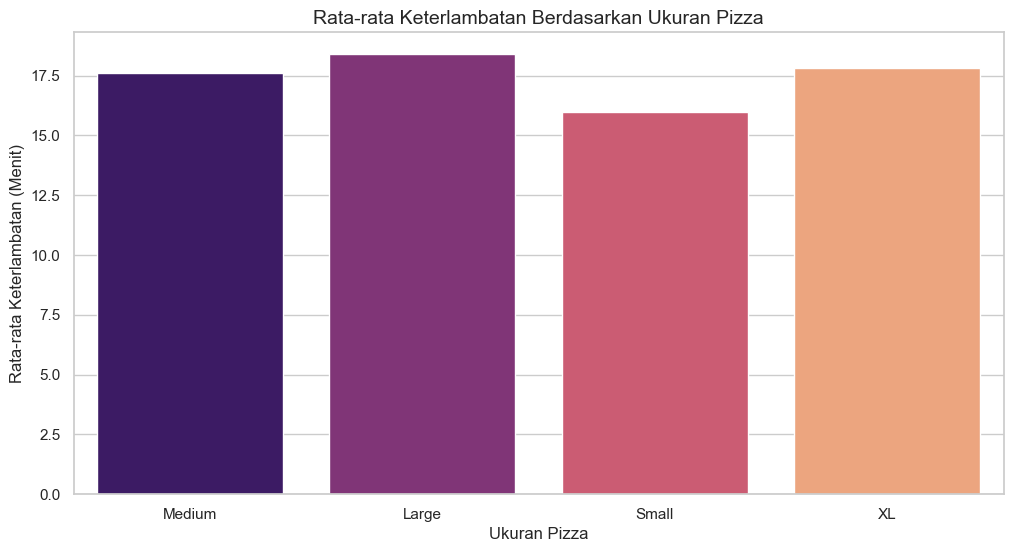

In [20]:
# Analisis Kompleksitas Pesanan (REVISI)
plt.figure(figsize=(12, 6))

# Menggunakan barplot untuk melihat rata-rata keterlambatan per ukuran pizza
sns.barplot(
    x='Pizza Size', 
    y='Gap Time (min)', 
    data=df, 
    palette='magma', 
    errorbar=None,
    hue='Pizza Size', 
    legend=False       
) 

plt.title('Rata-rata Keterlambatan Berdasarkan Ukuran Pizza', fontsize=14)
plt.ylabel('Rata-rata Keterlambatan (Menit)')
plt.xlabel('Ukuran Pizza')
plt.show()

#### Insight:

Grafik menunjukkan batang yang tingginya hampir sama, artinya ukuran pizza (Small vs XL) tidak terlalu signifikan mempengaruhi Gap keterlambatan dibanding faktor jalan raya. Dari grafik, terlihat ada pengaruh tapi selisihnya tipis (2-3 menit).

## Kesimpulan & Rekomendasi
Dari visualisasi dan analisis di atas, masalah "100% Keterlambatan" kemungkinan besar disebabkan oleh:
1. Algoritma Estimasi yang Naif: Sistem hanya menghitung waktu berdasarkan jarak dengan asumsi kecepatan yang terlalu ideal/cepat.
2. Tidak Ada "Prep Time": Sistem tidak memasukkan waktu persiapan (masak) ke dalam estimasi total, atau waktu masaknya diset terlalu cepat.
3. Pengabaian Traffic: Sistem tidak menyesuaikan estimasi secara dinamis saat traffic High.